In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, Input
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/X_train.npy')
y_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/y_train.npy')
X_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/X_test.npy')
y_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/y_test.npy')
X_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/X_val.npy')
y_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/y_val.npy')

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(16893, 98) (16893, 2)
(2109, 98) (2109, 2)
(2088, 98) (2088, 2)


In [ ]:
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Conv1D, MaxPooling1D, Activation
from keras.layers import Reshape, Softmax, Permute, Multiply, dot, concatenate
from keras.layers import BatchNormalization
from keras.models import Model
from keras.regularizers import l2

inputs = Input(shape=(98,1))
conv1 = Conv1D(32, 5, activation='relu', kernel_regularizer=l2(0.01))(inputs)
pool1 = MaxPooling1D(2)(conv1)
conv2 = Conv1D(64, 5, activation='relu')(pool1)
pool2 = MaxPooling1D(2)(conv2)
conv3 = Conv1D(128, 5, activation='relu')(pool2)
pool3 = MaxPooling1D(2)(conv3)

gru1 = GRU(128, return_sequences=True)(pool3)
gru2 = GRU(128)(gru1)
gru2 = Dropout(0.2)(gru2)

q = Dense(128)(gru2)
k = Dense(128)(gru2)
v = Dense(128)(gru2)

q = Reshape((1, 128))(q)
k = Reshape((1, 128))(k)
v = Reshape((1, 128))(v)

attention = dot([q, k], axes=[2, 2])
attention = Activation('softmax')(attention)

output = dot([attention, v], axes=[2, 1])
output = Reshape((128,))(output)

output = Dense(2, activation='softmax')(output)

model = Model(inputs=inputs, outputs=output)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 98, 1)]      0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 94, 32)       192         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 47, 32)      0           ['conv1d_3[0][0]']               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 43, 64)       10304       ['max_pooling1d_3[0][0]']        
                                                                                            

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(amsgrad=True,lr=0.001),
    metrics=['accuracy']
)

In [ ]:
print("Model Score: \n")
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 120)

Model Score: 

Epoch 1/120
528/528 [==============================] - 12s 10ms/step - loss: 0.3929 - accuracy: 0.8112 - val_loss: 0.2443 - val_accuracy: 0.9195
Epoch 2/120
528/528 [==============================] - 5s 10ms/step - loss: 0.2012 - accuracy: 0.9293 - val_loss: 0.1927 - val_accuracy: 0.9344
Epoch 3/120
528/528 [==============================] - 5s 10ms/step - loss: 0.1737 - accuracy: 0.9390 - val_loss: 0.1809 - val_accuracy: 0.9387
Epoch 4/120
528/528 [==============================] - 5s 9ms/step - loss: 0.1552 - accuracy: 0.9475 - val_loss: 0.1900 - val_accuracy: 0.9320
Epoch 5/120
528/528 [==============================] - 6s 11ms/step - loss: 0.1404 - accuracy: 0.9518 - val_loss: 0.1635 - val_accuracy: 0.9435
Epoch 6/120
528/528 [==============================] - 5s 9ms/step - loss: 0.1288 - accuracy: 0.9555 - val_loss: 0.1451 - val_accuracy: 0.9516
Epoch 7/120
528/528 [==============================] - 5s 9ms/step - loss: 0.1200 - accuracy: 0.9593 - val_loss: 0.1412 - 

In [ ]:
model.save("/content/gdrive/MyDrive/Colab Notebooks/FYP/CRNN-Regularized-WithAttention.h5")
score = model.evaluate(X_test, y_test)
print(score)

66/66 [==============================] - 0s 4ms/step - loss: 0.1602 - accuracy: 0.9810
[0.16017651557922363, 0.9810336828231812]


In [ ]:
pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 KB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9472 sha256=342e811f818fdb02f6cbb0e024560b4239904b3de44929ca637325870c9ea571
  Stored in directory: /root/.cache/pip/wheels/97/a5/76/35ae3e15da1ce4530de8591b0bcd7716f6d6752a4808f01c04
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320514 sha256=8cbcba7adb87ef869522f11b642659eea8ea52e9e17cd14429f083fdcc095e7f
  Stored in directory: /root/.cache/pip/wheels/a3/5f/ba/ddd191edb6c749a63cffabd28714d5600b5b58014daf7434a8
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

(<Figure size 1000x500 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

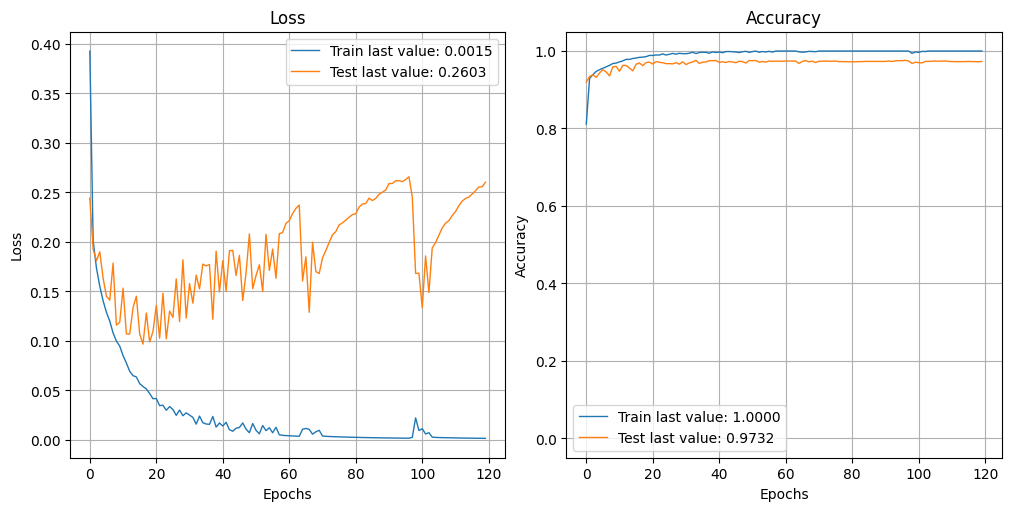

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
plot_history(history)

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Model Classification Report: 

66/66 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1049
           1       0.98      0.98      0.98      1060

    accuracy                           0.98      2109
   macro avg       0.98      0.98      0.98      2109
weighted avg       0.98      0.98      0.98      2109

Confusion matrix, without normalization
[[1030   19]
 [  21 1039]]


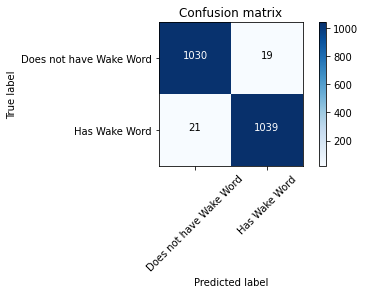

In [ ]:
print("Model Classification Report: \n")
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(classification_report(np.argmax(y_test, axis=1), y_pred))
plot_confusion_matrix(cm, classes=["Does not have Wake Word", "Has Wake Word"])